In [0]:
# Import required pacakges
import numpy as np

# ML packages
import tensorflow as tf

# Visualization packages
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

%matplotlib inline

In [2]:
numDimensions = 2

# Sample data from a 1-D (univariate) or 2-D (bivariate) Gaussian distribution with a specific mean and a specific variance
numSamples = 5000

if numDimensions == 1:
  # For univariate Gaussian distribution
  mean = np.random.random()
  stdDev = np.random.random()
  
  data = np.random.normal(loc=mean, scale=stdDev, size=numSamples)

else:
  # For bivariate Gaussian distribution
  mean = (np.random.random(), np.random.random())
  stdDev = (np.random.random(), np.random.random())
  covMat = [[stdDev[0], 0.0], [0.0, stdDev[1]]] # No covariance shift

  data = np.random.multivariate_normal(mean=mean, cov=covMat, size=numSamples)

print ("Mean:", mean, "| Standard Deviation:", stdDev, "| Data shape:", data.shape)

Mean: (0.9661752928318718, 0.13836026697848147) | Standard Deviation: (0.8104370057228769, 0.00717007277831716) | Data shape: (5000, 2)


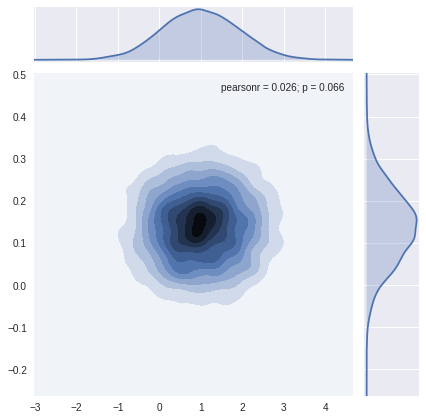

In [3]:
# Create the distribution plot
sns.set(color_codes=True)
if numDimensions == 1:
  sns.distplot(data)
else:
  sns.jointplot(x=data[:, 0], y=data[:, 1], kind="kde")

In [4]:
# Create the GAN network
numIterations = 1000
learningRate = 1e-2
batchSize = 100

noiseDimensions = 1
uniformNoiseSampling = True

# Clear previous graph
tf.reset_default_graph()

noisePlaceholder = tf.placeholder(tf.float32, shape=(None, noiseDimensions), name="noisePlaceholder")
dataPointPlaceholder = tf.placeholder(tf.float32, shape=(None, numDimensions), name="dataPointPlaceholder")

# Create the model variables
def addMLPNode(dataInput, outDim):
	W = tf.Variable(tf.random_normal([int(dataInput.get_shape()[-1]), outDim]))
	b = tf.Variable(tf.zeros([outDim]))
	y = tf.matmul(dataInput, W) + b
	return y

# Define the Generator
with tf.name_scope('Generator') as scope:
  generator = tf.nn.tanh(addMLPNode(noisePlaceholder, 5))
  generator = tf.nn.tanh(addMLPNode(generator, 10))
  generator = tf.nn.tanh(addMLPNode(generator, 20))
  generator = tf.nn.tanh(addMLPNode(generator, 10))
  generatedPoints = addMLPNode(generator, numDimensions)

# Concatenate the normal normal points and the generated points
points = tf.concat((dataPointPlaceholder, generatedPoints), axis=0)
labels = tf.concat((tf.ones(tf.shape(dataPointPlaceholder)[0]), tf.zeros(tf.shape(dataPointPlaceholder)[0])), axis=0)

# Define the Discriminator
with tf.name_scope('Discriminator') as scope:
  discriminator = tf.nn.tanh(addMLPNode(points, 5))
  discriminator = tf.nn.tanh(addMLPNode(discriminator, 10))
  discriminator = tf.nn.sigmoid(addMLPNode(discriminator, 1))
  y = tf.reshape(discriminator, [-1])

# Define the loss function
epsilon = 1e-8
with tf.name_scope('loss') as scope:
  loss = tf.reduce_mean((labels * tf.log(y + epsilon)) + ((1.0 - labels) * tf.log(1.0 - y + epsilon)))
  generatorLoss = tf.reduce_mean(((1.0 - labels) * tf.log(y + epsilon))) # To avoid saturation of (1 - D(G(z)))

with tf.name_scope('accuracy'):
	correctPredictions = tf.equal(tf.round(y), tf.round(labels))
	accuracy = tf.reduce_mean(tf.cast(correctPredictions, tf.float32), name='accuracy')
  
generatorVars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Generator")
discriminatorVars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Discriminator")
print ("Generator vars:", generatorVars)
print ("Discriminator vars:", discriminatorVars)
  
with tf.name_scope('optimizer') as scope:
  optimizerDiscriminator = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(-loss, var_list=discriminatorVars) # Discriminator should maximize the loss
  # optimizerGenerator = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(loss, var_list=generatorVars) # Generator should minimize the normal loss (saturates)
  optimizerGenerator = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(-generatorLoss, var_list=generatorVars) # Generator should maximize log D(G(z))

Generator vars: [<tf.Variable 'Generator/Variable:0' shape=(1, 5) dtype=float32_ref>, <tf.Variable 'Generator/Variable_1:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'Generator/Variable_2:0' shape=(5, 10) dtype=float32_ref>, <tf.Variable 'Generator/Variable_3:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'Generator/Variable_4:0' shape=(10, 20) dtype=float32_ref>, <tf.Variable 'Generator/Variable_5:0' shape=(20,) dtype=float32_ref>, <tf.Variable 'Generator/Variable_6:0' shape=(20, 10) dtype=float32_ref>, <tf.Variable 'Generator/Variable_7:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'Generator/Variable_8:0' shape=(10, 2) dtype=float32_ref>, <tf.Variable 'Generator/Variable_9:0' shape=(2,) dtype=float32_ref>]
Discriminator vars: [<tf.Variable 'Discriminator/Variable:0' shape=(2, 5) dtype=float32_ref>, <tf.Variable 'Discriminator/Variable_1:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'Discriminator/Variable_2:0' shape=(5, 10) dtype=float32_ref>, <tf.Variable 'Discriminator/Varia

In [5]:
# Train the model
print ("Training model")
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
  # Initializing the variables
  init = tf.global_variables_initializer()
  sess.run(init)

  k = 2
  for i in range(numIterations):
    for iteration in range(k):
      optimizeGenerator = False
      if iteration == k-1:
        optimizeGenerator = True
      
      if uniformNoiseSampling:
        noise = np.random.uniform(low=-1.0, high=1.0, size=[batchSize, 1])
      else:
        noise = np.random.random(size=[batchSize, 1])
      randomPointIndices = np.random.choice(np.arange(numSamples), size=[batchSize])
      if optimizeGenerator:
        _, trainLoss, trainAccuracy = sess.run([optimizerGenerator, generatorLoss, accuracy], feed_dict={noisePlaceholder: noise, dataPointPlaceholder: data[randomPointIndices, :]})
      else:
        _, trainLoss, trainAccuracy = sess.run([optimizerDiscriminator, loss, accuracy], feed_dict={noisePlaceholder: noise, dataPointPlaceholder: data[randomPointIndices, :]})
      print ("Iteration: %d | Optimizing: %s | Loss: %f | Discriminator Accuracy: %f" % (i + 1, "Generator" if optimizeGenerator else "Discriminator", -trainLoss, trainAccuracy))
  print ("Training finished!")
  
  # Plot the discovered distribution of the generator
  if uniformNoiseSampling:
    latentSpaceInterpolation = np.expand_dims(np.arange(-1, 1, 0.01), axis=-1)
  else:
    latentSpaceInterpolation = np.expand_dims(np.arange(0, 1, 0.01), axis=-1)
  generatedPointsWithInterpolation = sess.run(generatedPoints, feed_dict={noisePlaceholder: latentSpaceInterpolation})

Training model
Iteration: 1 | Optimizing: Discriminator | Loss: 0.635520 | Discriminator Accuracy: 0.670000
Iteration: 1 | Optimizing: Generator | Loss: 0.448283 | Discriminator Accuracy: 0.645000
Iteration: 2 | Optimizing: Discriminator | Loss: 0.662596 | Discriminator Accuracy: 0.635000
Iteration: 2 | Optimizing: Generator | Loss: 0.394134 | Discriminator Accuracy: 0.685000
Iteration: 3 | Optimizing: Discriminator | Loss: 0.591874 | Discriminator Accuracy: 0.685000
Iteration: 3 | Optimizing: Generator | Loss: 0.330596 | Discriminator Accuracy: 0.620000
Iteration: 4 | Optimizing: Discriminator | Loss: 0.611025 | Discriminator Accuracy: 0.595000
Iteration: 4 | Optimizing: Generator | Loss: 0.333159 | Discriminator Accuracy: 0.670000
Iteration: 5 | Optimizing: Discriminator | Loss: 0.571775 | Discriminator Accuracy: 0.655000
Iteration: 5 | Optimizing: Generator | Loss: 0.349376 | Discriminator Accuracy: 0.670000
Iteration: 6 | Optimizing: Discriminator | Loss: 0.542950 | Discriminator A

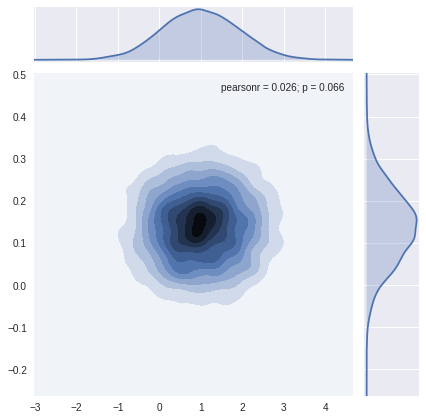

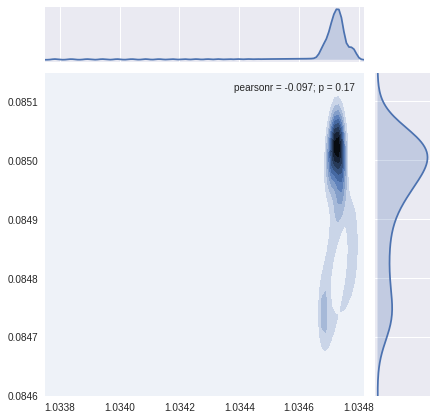

In [6]:
# Plot the generator distribution
if numDimensions == 1:
  sns.distplot(data) # Data generating distribution
  sns.distplot(generatedPointsWithInterpolation) # Discovered distribution
else:
  sns.jointplot(x=data[:, 0], y=data[:, 1], kind="kde") # Data generating distribution
  sns.jointplot(x=generatedPointsWithInterpolation[:, 0], y=generatedPointsWithInterpolation[:, 1], kind="kde")  # Discovered distribution